In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [96]:
# Create function to convert colors: rgb_colors
def rgb_color(r,g,b):
    r = r/255.
    g = g/255.
    b = b/255.
    return(r,g,b)

# Create colors:
tableau_blue = rgb_color(31,119,180)
tableau_grey = rgb_color(127,127,127)
tableau_light = rgb_color(162,162,162)

In [4]:
# Load in data: df
df = pd.read_csv('https://s3.amazonaws.com/clcarverloans/data/df_cluster.csv')

In [5]:
# Remove usesless rows: df_select
cols = ['Borrower_Genders', 'Country Code', 'Loan Amount', 'Lender_Term', 'Repayment_Interval', 'Distribution_Model', 'Sector', 'Activity','Cluster','Delinquent']
df_select = df[cols]
df_select = df_select.dropna()

# One_hot_encode categorical columns: df_dummies
df_dummies = pd.get_dummies(df_select)

# Select features and target: X, y
y = df_dummies.pop('Delinquent')
X = df_dummies

In [6]:
# Split data into train and test set: train_set, test_set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Test Models

In [7]:
# Build function to evaluate model and build ROC curves: eval_model
def eval_model(model, X_train, X_test, y_train, y_test, color, ax, width=1):
    model.fit(X_train, y_train)
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    ax.plot(fpr, tpr, label=model.__class__.__name__, color=color, linewidth=width)
    plt.xlabel('% of Good Borrowers Blocked')
    plt.ylabel('% of Defaulters Blocked')    

In [8]:
# Create a list of models to test
model_list = [DecisionTreeClassifier(class_weight={0:1, 1:24}), KNeighborsClassifier(), LogisticRegression(class_weight={0:1, 1:24}), RandomForestClassifier(class_weight={0:1, 1:24}), GradientBoostingClassifier()]

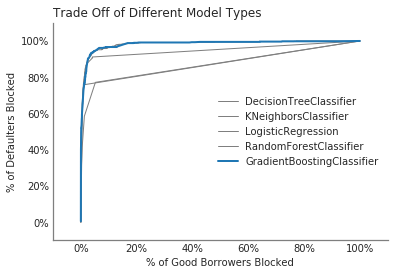

In [10]:
labels=[str(int(round(label*100)))+'%' for label in np.arange(0,1.2,0.2)] 

fig, ax = plt.subplots()
for model in model_list[0:4]:
    eval_model(model, X_train, X_test, y_train, y_test, tableau_grey, ax, width=1)
eval_model(model_list[4], X_train, X_test, y_train, y_test, tableau_blue, ax=ax, width=2)
ax.spines['right'].set_visible(False) 
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_color(tableau_grey) 
ax.spines['left'].set_color(tableau_grey)
plt.margins(0.1)
plt.title('Trade Off of Different Model Types', loc='left')
plt.xticks(np.arange(0,1.2,0.2), labels)
plt.yticks(np.arange(0,1.2,0.2), labels)
plt.legend(loc='center right')
plt.show()

In [18]:
# Build function to score each model: model_scoree
def model_score(model, X_train, X_test, y_train, y_test, sub_plot, i):
    model.fit(X_train, y_train)
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    y_pred = model.predict(X_test)
    
    CM = confusion_matrix(y_test, y_pred)
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    
    plt.subplot(2,3,i+1)
    plt.subplots_adjust(hspace=0.5, wspace=0.3)
    plt.plot(fpr, tpr, color=tableau_blue, linewidth=2)
    plt.title(model.__class__.__name__, fontsize=8)
    plt.text(0.2, 0.5, ('FPR : {}'.format(round(FP/(FP+TN), 3))), fontsize=8)
    plt.text(0.2, 0.3, ("Recall : {}".format(round(recall_score(y_test, y_pred), 3))), fontsize=8)

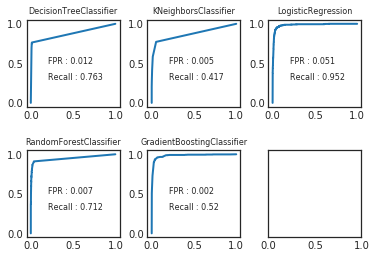

In [19]:
plt.figure(figsize=(8,12))
sub_plot = plt.subplots(2,3, sharex=True, sharey=True)
for i, model in enumerate(model_list):
    model_score(model, X_train, X_test, y_train, y_test, sub_plot, i)
plt.savefig('../pictures/model_testing.png', dpi=600, transparent=True)
plt.show()

In [7]:
final_model_list = model_list = [LogisticRegression(class_weight={0:1, 1:24}), RandomForestClassifier(class_weight={0:1, 1:24}), GradientBoostingClassifier()]

In [121]:
# Build function to compare models FPR and TPR
def model_score(model, X_train, X_test, y_train, y_test, sub_plot, i):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    CM = confusion_matrix(y_test, y_pred)
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    recall = round(TP/(TP+FN), 3)
    fpr = round(FP/(FP+TN), 3)
    
    ax = plt.subplot(3,1,i+1)
    plt.subplots_adjust(hspace=1)
    ax.barh(['% of Defaulters Blocked', '% of Good Borrowers Accidentally Blocked'], [recall, fpr], color=tableau_blue)
    ax.spines['right'].set_visible(False) 
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_color(tableau_light)
    ax.axes.get_xaxis().set_ticks([])
    plt.text((fpr + 0.02) , 1, (str(round(fpr*100, 2))+'%'), color=tableau_blue, weight='bold')
    plt.text((recall + 0.02) , 0, (str(round(recall*100, 2))+'%'), color=tableau_blue, weight='bold')
    plt.xlim(0,1)
    plt.yticks(['% of Defaulters Blocked', '% of Good Borrowers Accidentally Blocked'], color=tableau_grey)
    plt.title(model.__class__.__name__, fontsize=12, color=tableau_grey)

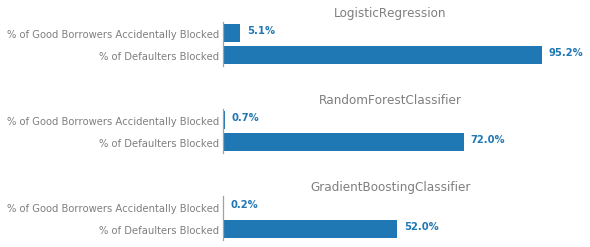

In [122]:
plt.figure(figsize=(16,8))
sub_plot = plt.subplots(3,1, sharex=True, sharey=True)
for i, model in enumerate(model_list):
    model_score(model, X_train, X_test, y_train, y_test, sub_plot, i)
plt.savefig('../pictures/recall_vs_fpr.png', dpi=600, transparent=True, bbox_inches='tight')
plt.show()